In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Load all files
for n in range(1,nfiles+1):

    with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
      infiles = json.load(f)
    
    filename = '/myeosdir/vbf-category/outfiles/'+year+'_'+str(n)+'.coffea'
    #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
    if os.path.isfile(filename):
        out = util.load(filename)
        outsum.add(out)
    else:
        print(n,infiles.keys())
        #print("File " + filename + " is missing")
          
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}

scale_lumi['JetHT'] = 1
scale_lumi['SingleMuon'] = 1

outsum['templates-vbf'].scale(scale_lumi, 'dataset')
outsum['muonkin'].scale(scale_lumi, 'dataset')
outsum['mujetkin'].scale(scale_lumi, 'dataset')
outsum['cutflow'].scale(scale_lumi, 'dataset')
print('ok')

2416 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
ok


In [5]:
cutflow = outsum['cutflow'].group('dataset', hist.Cat('process', 'Process'), pmap).sum('genflavor').integrate('region','muoncontrol')

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9c801c3280>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


In [6]:
cutflow.integrate('process','muondata').values()

{(): array([2.9164308e+07, 1.6151331e+07, 5.8711900e+05, 5.8711900e+05,
        1.9092900e+05, 5.2448000e+04, 4.8654000e+04, 7.7040000e+03,
        4.0390000e+03, 3.3900000e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00])}

In [7]:
cutflow.integrate('process','ttbar').values()

{(): array([3.14403712e+07, 3.14403712e+07, 3.04214899e+05, 3.04214899e+05,
        1.03883683e+05, 4.97797608e+04, 3.75543905e+04, 4.89521571e+03,
        2.78967245e+03, 2.94268530e+02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00])}

In [8]:
df1 = pd.DataFrame([])

df1['QCD'] = cutflow.values()[('QCD',)]
df1['Wjets'] = cutflow.values()[('Wjets',)]
df1['Zjets'] = cutflow.values()[('Zjets',)]
df1['VV'] = cutflow.values()[('VV',)]
df1['ttbar'] = cutflow.values()[('ttbar',)]
df1['singlet'] = cutflow.values()[('singlet',)]
df1['data'] = cutflow.values()[('muondata',)]

df1 = df1[1:10].astype('int')
df1.index = ['Jet kinematics','Jet ID','Jet $N_2^\text{DDT}$','b-tag','No e/tau','One muon','Dphi(muon,AK8)','AK4jets','DeepDoubleB']
df1.to_latex(buf=year+'/cutflow-muoncr.tex')

In [9]:
deta_cut = 2
mjj_cut = 500

In [10]:
templates = outsum['templates-vbf'].group('dataset', hist.Cat('process', 'Process'), pmap).integrate('systematic','nominal')
muonkin = outsum['muonkin'].group('dataset', hist.Cat('process', 'Process'), pmap)
mujetkin = outsum['mujetkin'].group('dataset', hist.Cat('process', 'Process'), pmap)

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9c792bb130>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9c792cd760>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9c792cdf10>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c80181340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c80181340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in tru

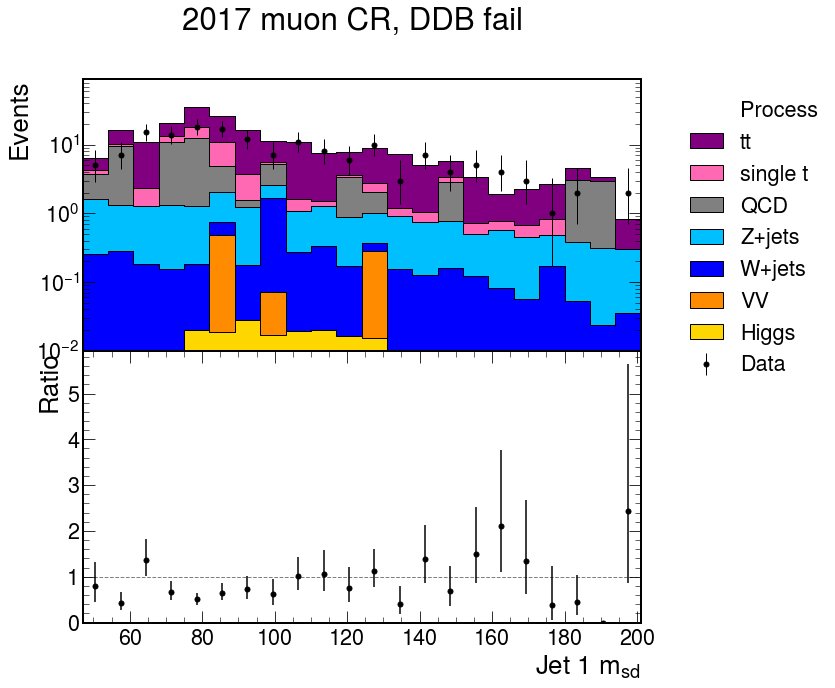

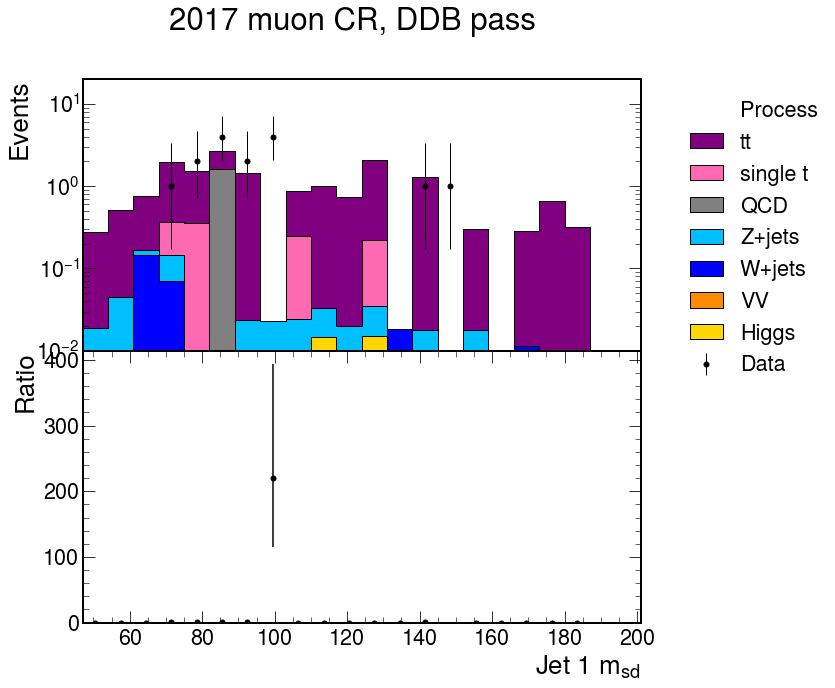

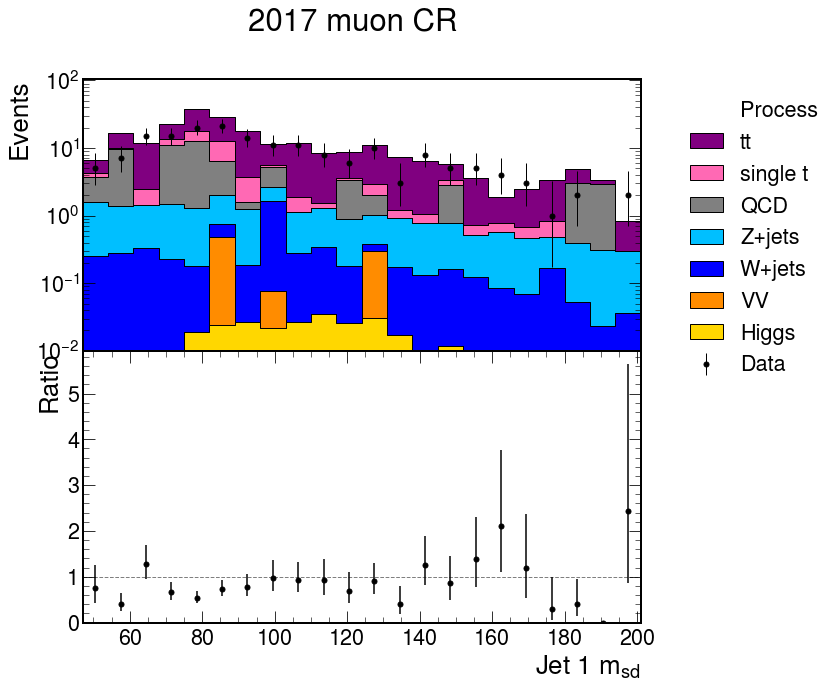

In [11]:
h = templates.integrate('region', 'muoncontrol').sum('pt1').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1_fail',year+" muon CR, DDB fail")
h = templates.integrate('region', 'muoncontrol').sum('pt1').integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1_pass',year+" muon CR, DDB pass")
h = templates.integrate('region', 'muoncontrol').sum('ddb1','pt1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c80181340>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


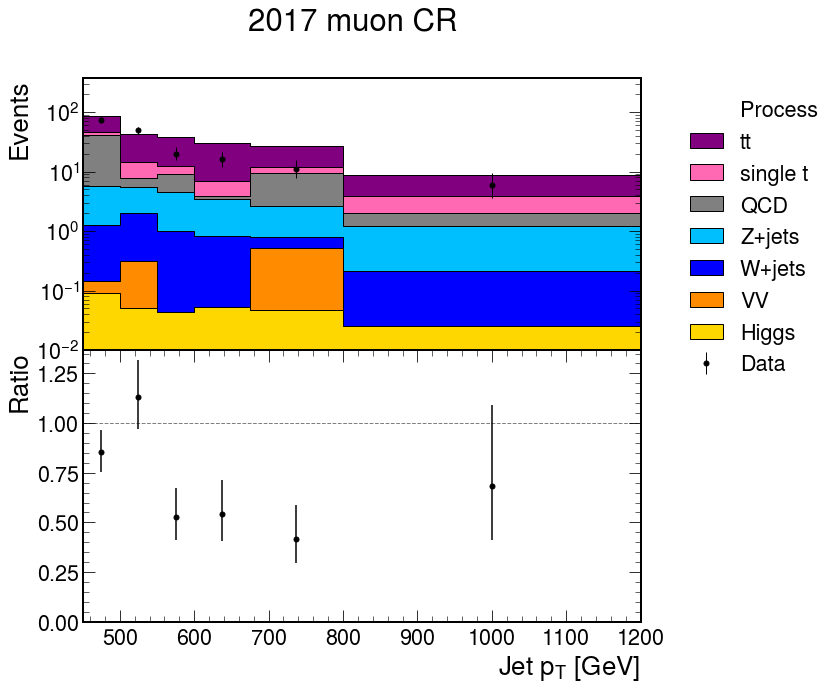

In [12]:
h = templates.integrate('region', 'muoncontrol').sum('ddb1','msd1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_pt1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c80181ac0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


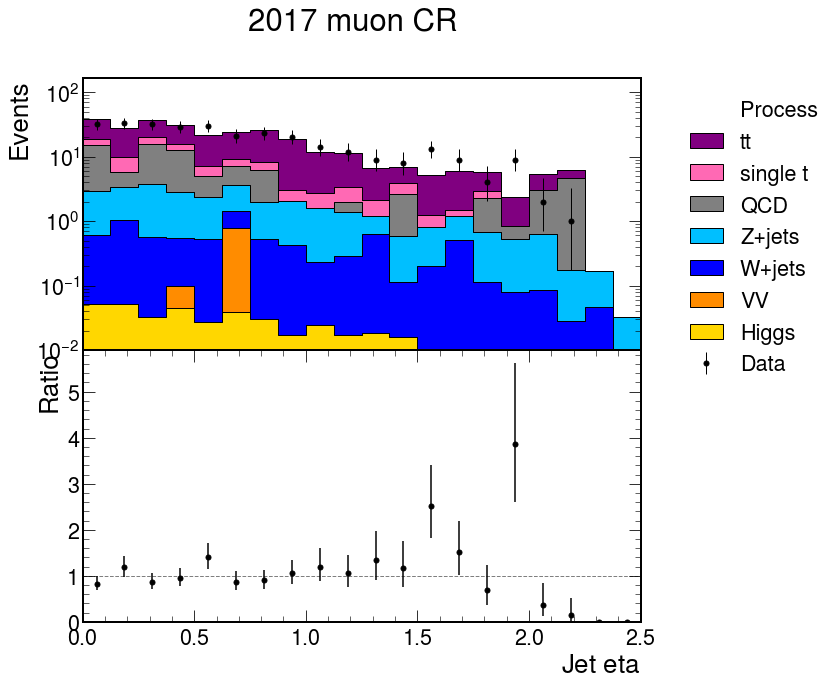

In [13]:
h = mujetkin.integrate('region', 'muoncontrol').sum('ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_msd1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c80181ac0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


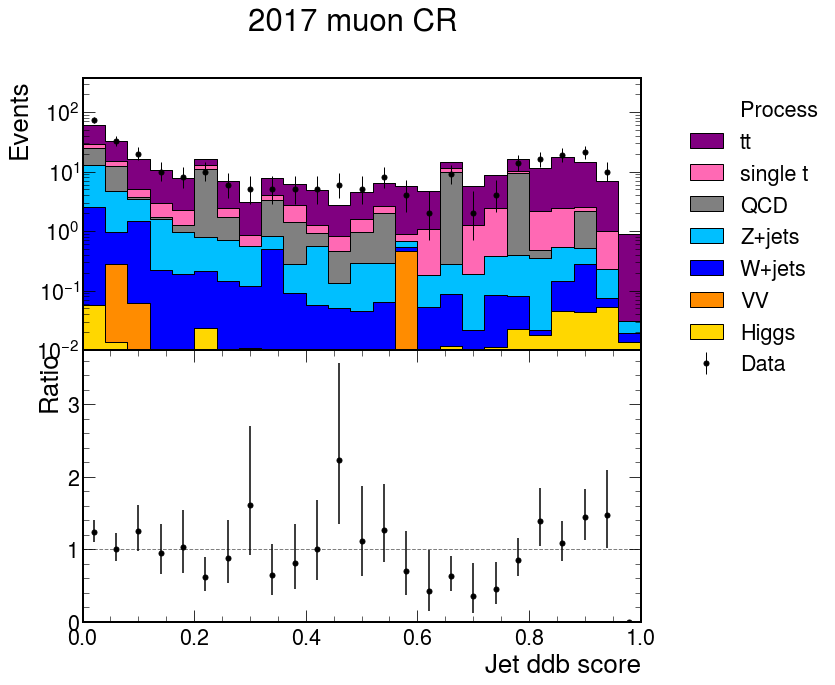

In [14]:
h = mujetkin.integrate('region', 'muoncontrol').sum('eta1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ddb1',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c801813d0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c

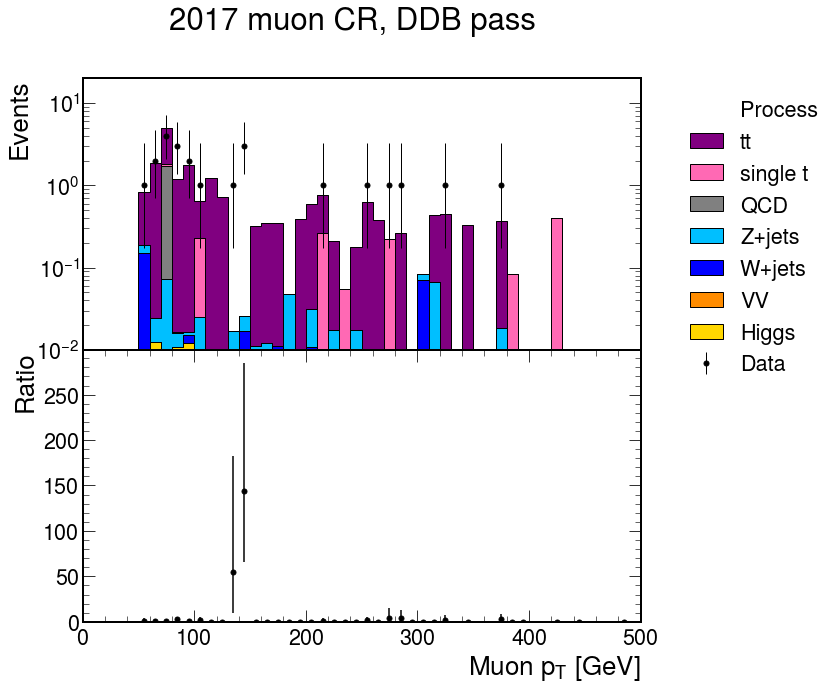

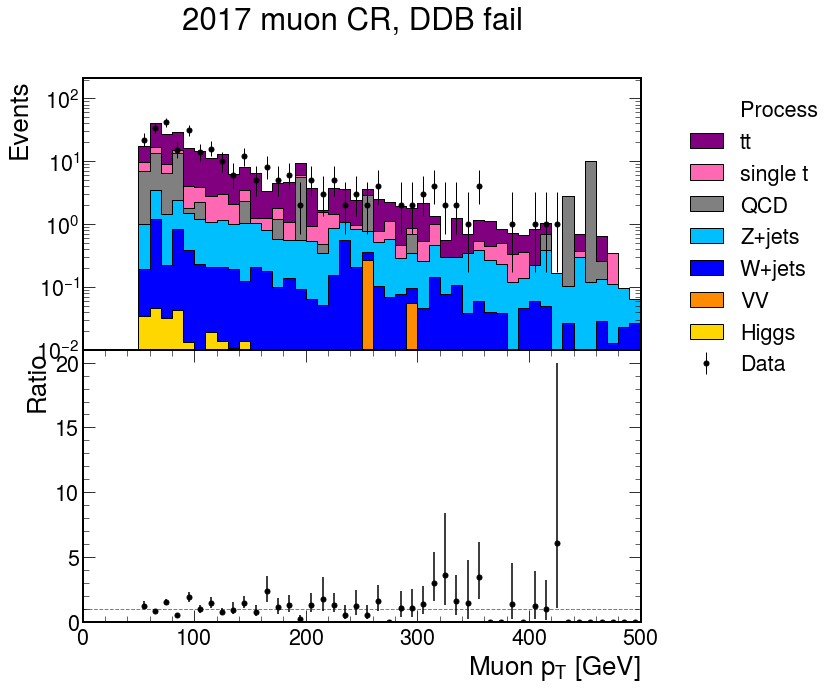

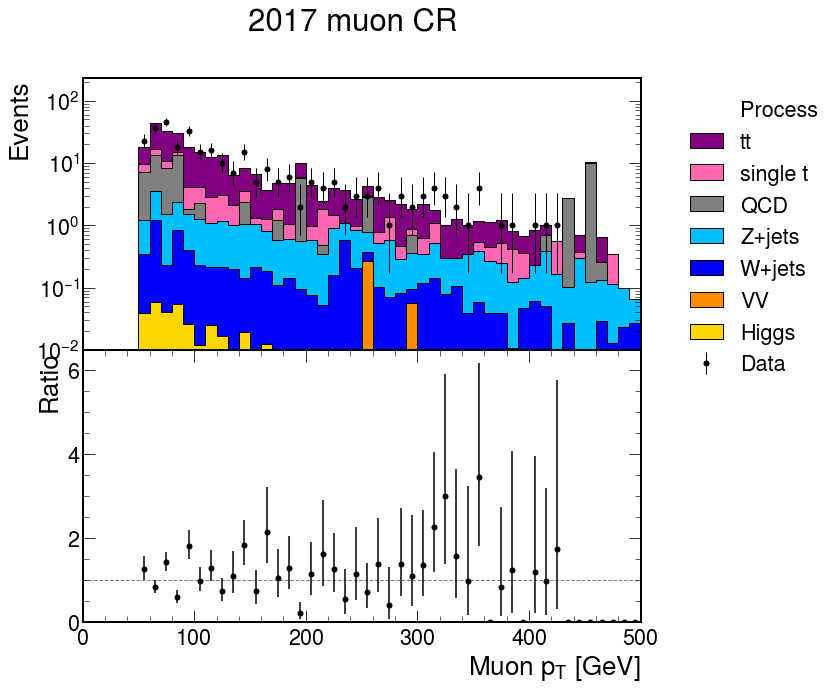

In [15]:
h = muonkin.integrate('region', 'muoncontrol').sum('etamu',).integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('etamu','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_ptmu',year+" muon CR")

/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c801813d0>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:347: RuntimeWarning: Not all requested indices present in <Cat (name=process) instance at 0x7f9c

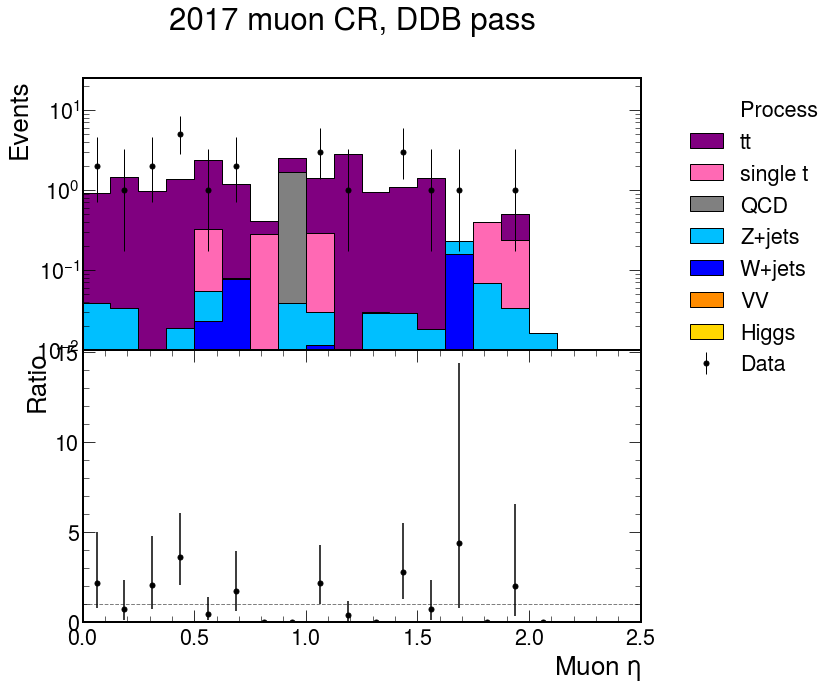

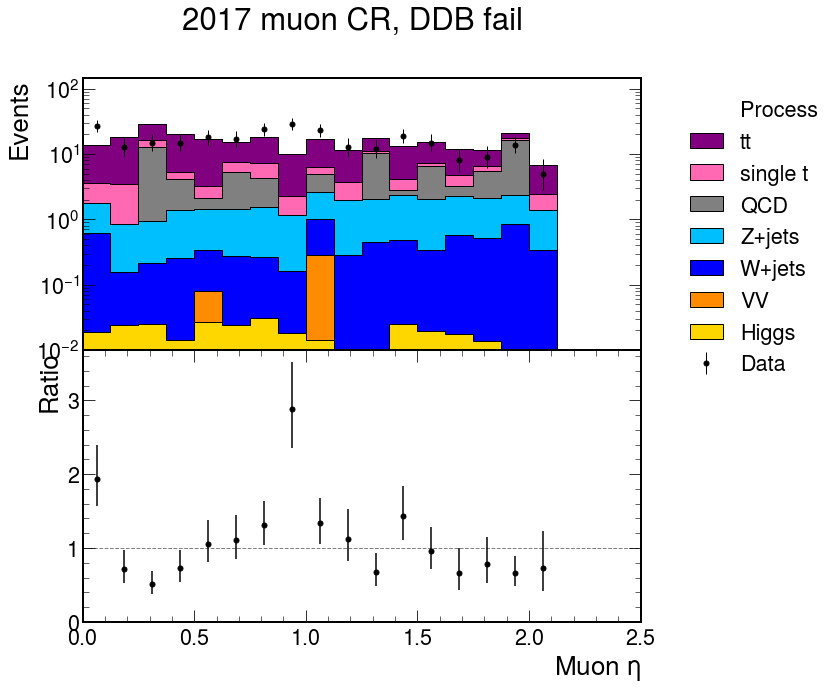

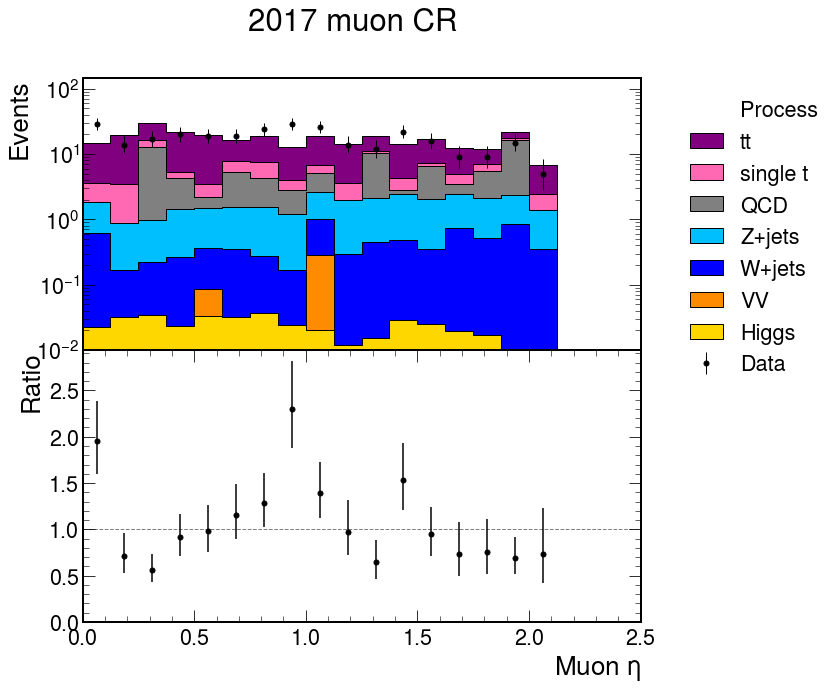

In [16]:
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0.89,1)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu_pass',year+" muon CR, DDB pass")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu').integrate('ddb1',int_range=slice(0,0.89)).integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu_fail',year+" muon CR, DDB fail")
h = muonkin.integrate('region', 'muoncontrol').sum('ptmu','ddb1').integrate('deta',int_range=slice(deta_cut,7)).integrate('mjj',int_range=slice(mjj_cut,4000))
plot_datamc_muoncr(h,year+'/muCR_etamu',year+" muon CR")